In [1]:
import os
os.environ['PATH'] += ":/content/mumax3.10"

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

In [4]:
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

In [5]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

In [6]:
script="""
SetGridsize(128, 32, 1)
SetCellsize(500e-9/128, 125e-9/32, 3e-9)

Msat  = 800e3
Aex   = 13e-12
alpha = 0.02

m = uniform(1, .1, 0)
relax()

autosave(m, 200e-12)
tableadd(e_total)
tableautosave(10e-12)

B_ext = vector(-24.6E-3, 4.3E-3, 0)
run(1e-9)
"""

In [7]:
table, fields = run_mumax3( script, name="standardproblem4", verbose=False )

                t        mx        my        mz       E_total
0    0.000000e+00  0.966966  0.125281  0.000000  4.113432e-18
1    1.082935e-11  0.963695  0.136324 -0.013508  4.112599e-18
2    2.016690e-11  0.955261  0.162340 -0.024556  4.110129e-18
3    3.048723e-11  0.938439  0.206812 -0.035843  4.103999e-18
4    4.055433e-11  0.912671  0.263159 -0.045624  4.093605e-18
..            ...       ...       ...       ...           ...
96   9.600765e-10 -0.969286 -0.076157 -0.003017 -2.656983e-18
97   9.703074e-10 -0.975416 -0.061169  0.017145 -2.666208e-18
98   9.805337e-10 -0.983918 -0.014050  0.033343 -2.680082e-18
99   9.900772e-10 -0.988076  0.050585  0.042178 -2.698025e-18
100  1.000000e-09 -0.984612  0.126047  0.043269 -2.718246e-18

[101 rows x 5 columns]


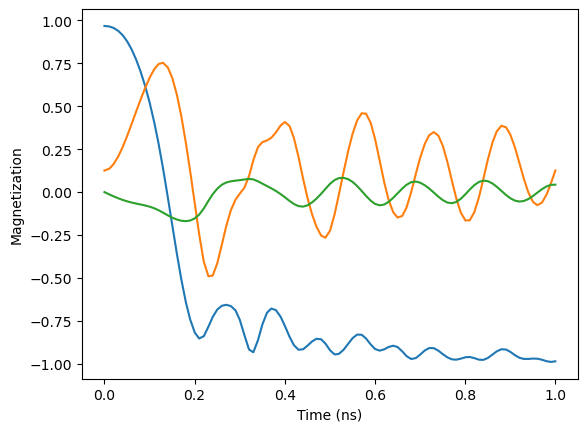

In [8]:
print(table)

plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"])
plt.plot( table["t"]/nanosecond, table["my"])
plt.plot( table["t"]/nanosecond, table["mz"])

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

In [9]:
script ="""
// Racetrack crystal settings:
length := 500e-9
width := 50e-9;
delta := 2*width; lattice_constant := 2*delta;
N_unitcells := 8
Nx := 128; Ny := 512; Nz := 1
Lx := length; Ly := N_unitcells*lattice_constant; 
dX := length/Nx; dY := Ly/Ny; dZ := 1e-9/Nz

setGridSize(Nx, Ny, Nz)
setCellSize(dX, dY, dZ)

Msat    = 600e3
Aex     = 10e-12
anisU   = vector(0, 0, 1)
Ku1     = 0.59e6
alpha   = 0.02 
Xi      = 0.2
pinning := false

racetrack := rect(length, width)

if(pinning){
  // make notches
}

saveAs(geom, "racetrack_crystal")

y0 := Ly/2 - width/2;
for i:=0; i<n_unitcells; i+=1 {
  // Racetrack A center
  yA := y0 - (i*lattice_constant);

  // Racetrack B center
  yB := y0 - (i*lattice_constant + delta);

  setGeom(racetrack.transl(0, delta*i, 0))
  m  = twoDomain(0, 0, 1, 1, 1, 0, 0, 0, -1) // up-down domains with wall between Bloch and Néél type
  defRegion(2*i,   rect(length,width).transl(0, delta*i, 0))
  defRegion(2*i+1, rect(length,width).transl(0, delta*i, 0))
}
relax()

// Set post-step function that centers simulation window on domain wall.
//ext_centerWall(2) // keep m[2] (= m_z) close to zero

// Schedule output
autosave(m, 100e-12)

// Run for 1ns with current through the sample
j   = vector(1.5e13, 0, 0)
pol = 1
run(.5e-9)"""

In [10]:
table, fields = run_mumax3(script,"DWmotion")

//mumax 3.10 [linux_amd64 go1.17.3(gc) CUDA-11.5]
//GPU info: NVIDIA GeForce RTX 3060 Laptop GPU(6143MB), CUDA Driver 12.0, cc=8.6, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: DWmotion.out/
github.com/mumax/3/cmd/mumax3/main.go:110 script line 21: racetrack = rect(length,width): undefined: racetrack



In [11]:
# print(table)

# plt.figure()

# nanosecond = 1e-9
# plt.plot( table["t"]/nanosecond, table["mx"])
# plt.plot( table["t"]/nanosecond, table["my"])
# plt.plot( table["t"]/nanosecond, table["mz"])

# plt.xlabel("Time (ns)")
# plt.ylabel("Magnetization")

# plt.show()

None


TypeError: 'NoneType' object is not subscriptable

<Figure size 640x480 with 0 Axes>